In [1]:
import datetime

from gensim.models import KeyedVectors
from gensim.test import test_data
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
questions_en = '/home/levai/.miniconda3/envs/gensim/lib/python3.8/site-packages/gensim/test/test_data/questions-words.txt'

In [3]:
questions = '/mnt/permanent/Language/Hungarian/Embed/questions-words-hu/questions-words-hu.txt'

In [4]:
vectors_en = KeyedVectors.load('/mnt/permanent/Language/English/Embed/glove.840B.300d.gensim')

In [5]:
vectors = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/mnsz2/glf/mnsz-glf-sgram-600.gensim')

In [6]:
def get_analogy_scores(vectors, questions):
    score, sections = vectors.evaluate_word_analogies(questions, restrict_vocab=10000)
    #print(score)
    df_ = pd.DataFrame(sections)
    df_.set_index('section', inplace=True)
    df = df_.apply({'correct': len, 'incorrect': len})
    df['total'] = df.sum(axis=1)
    df['accuracy'] = df.correct / df.total
    df.drop(index=['Total accuracy'], inplace=True)
    return df

# Comparison of MNSZ-glf-sgram-600 to English

In [7]:
df_en = get_analogy_scores(vectors_en, questions_en)

In [8]:
df = get_analogy_scores(vectors, questions)

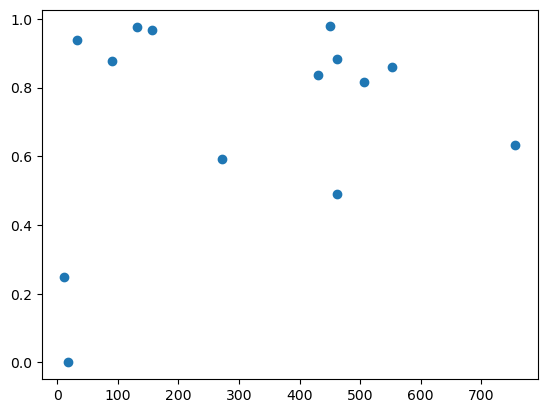

In [9]:
plt.scatter(df_en.total, df_en.accuracy)

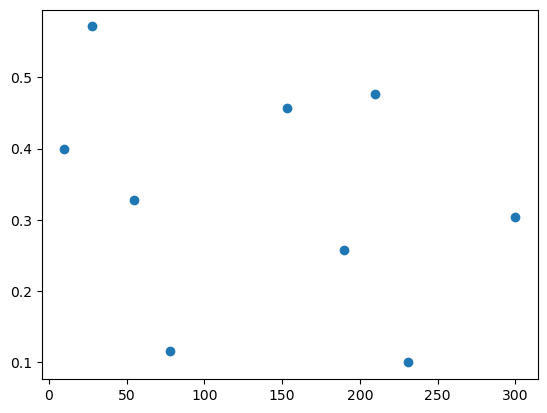

In [10]:
plt.scatter(df.total, df.accuracy)

# Webcorpus 2.0: gluten-free and vanila

In [11]:
def aggregate_score(model):
    df = get_analogy_scores(model, questions)
    df.drop(index=['capital-world', 'capital-common-countries'], inplace=True)
    # capital-world is disregarded because large OOV makes this relation instabile
    # [~df.index.str.startswith('gram')]
    return df.accuracy.mean()

In [12]:
embed_dir = '/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0'

In [13]:
file_patterns = ['2017_2018_2956', '2017_2018_295', '2017_2018_29', 'wiki', '2017_2018_2', '2017_2018']#, '201', ''

In [14]:
def get_accuracy_by_size():
    for file_pattern in file_patterns:
        for deglutinate_ in ['vanila', 'deglut', 'deglutAllSuffSepd']:
            try:
                model = KeyedVectors.load(f'{embed_dir}/sgns-300-{file_pattern}-{deglutinate_}.gensim')
            except FileNotFoundError:
                continue
            record = {
                'files': f'{file_pattern}*',
                'deglut' : deglutinate_,
                'sentence': model.corpus_count, 
                'token': model.corpus_total_words, 
                'type': len(model.wv.key_to_index)}
            df = get_analogy_scores(model.wv, questions)
            record['capital-common-countries correct'] = df.loc['capital-common-countries', 'correct']
            record['capital-common-countries total'] = df.loc['capital-common-countries', 'total']
            df.drop(index=['capital-world', 'capital-common-countries'], inplace=True)
            record['accuracy'] = df.accuracy.mean()
            print((record['files'], record['deglut']))
            yield record

In [15]:
records = get_accuracy_by_size()

In [16]:
df_ = pd.DataFrame(records)

('2017_2018_2956*', 'vanila')
('2017_2018_2956*', 'deglut')
('2017_2018_2956*', 'deglutAllSuffSepd')
('2017_2018_295*', 'vanila')
('2017_2018_295*', 'deglut')
('2017_2018_295*', 'deglutAllSuffSepd')
('2017_2018_29*', 'vanila')
('2017_2018_29*', 'deglut')
('2017_2018_29*', 'deglutAllSuffSepd')
('wiki*', 'vanila')
('wiki*', 'deglut')
('wiki*', 'deglutAllSuffSepd')
('2017_2018_2*', 'vanila')
('2017_2018_2*', 'deglut')
('2017_2018_2*', 'deglutAllSuffSepd')
('2017_2018*', 'vanila')
('2017_2018*', 'deglut')
('2017_2018*', 'deglutAllSuffSepd')


In [17]:
df_['capital-common-countries accuracy'] = df_['capital-common-countries correct']/df_['capital-common-countries total']

In [18]:
df = df_.drop(columns=['deglut', 'accuracy']).groupby('files').max()
df = df.join(pd.pivot_table(df_, values='accuracy', index='files', columns='deglut'), rsuffix='_')
df = df.join(pd.pivot_table(df_, values='capital-common-countries accuracy', index='files', columns='deglut'), 
             rsuffix='_capital-common-countries')
df.drop(columns=['capital-common-countries correct', 'capital-common-countries total'])
df.sort_values('sentence', inplace=True)

In [19]:
def thousand(int_):
    return f'{int_:,}'

In [20]:
df.apply({col: thousand if col in ['sentence', 'token', 'type'] else lambda x: x for col in df.columns})

,sentence,token,type,capital-common-countries correct,capital-common-countries total,capital-common-countries accuracy,deglut,deglutAllSuffSepd,vanila,deglut_capital-common-countries,deglutAllSuffSepd_capital-common-countries,vanila_capital-common-countries
files,,,,,,,,,,,,
2017_2018_2956*,"66,798","1,246,317","9,388",0,1,0.000000,0.033333,0.016667,0.000650,0.000000,0.000000,NaN
2017_2018_295*,"879,317","23,261,396","149,981",0,1,0.000000,0.048498,0.050489,0.073301,0.000000,0.000000,NaN
wiki*,"11,798,744","200,357,761","920,965",39,78,0.555556,0.301049,0.332903,0.461793,0.500000,0.461538,0.555556
2017_2018_29*,"12,058,626","310,703,112","1,028,343",8,15,1.000000,0.335747,0.317981,0.469687,0.533333,0.266667,1.000000
2017_2018_2*,"133,832,368","3,395,599,678","4,730,753",11,15,0.733333,0.505566,0.519638,0.579354,0.266667,0.733333,NaN
2017_2018*,"511,812,157","13,144,806,360","11,400,728",8,15,1.000000,0.430760,0.467365,0.618774,0.533333,0.400000,1.000000


In [21]:
df.columns

Index(['sentence', 'token', 'type', 'capital-common-countries correct',
       'capital-common-countries total', 'capital-common-countries accuracy',
       'deglut', 'deglutAllSuffSepd', 'vanila',
       'deglut_capital-common-countries',
       'deglutAllSuffSepd_capital-common-countries',
       'vanila_capital-common-countries'],
      dtype='object')

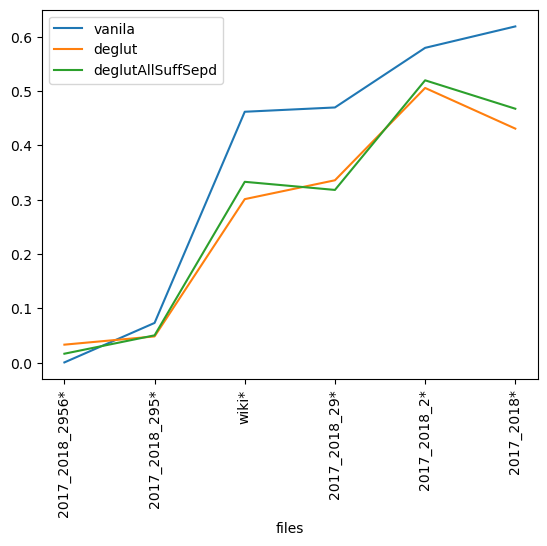

In [22]:
df[['vanila', 'deglut', 'deglutAllSuffSepd']].plot()
_ = plt.xticks(rotation=90)


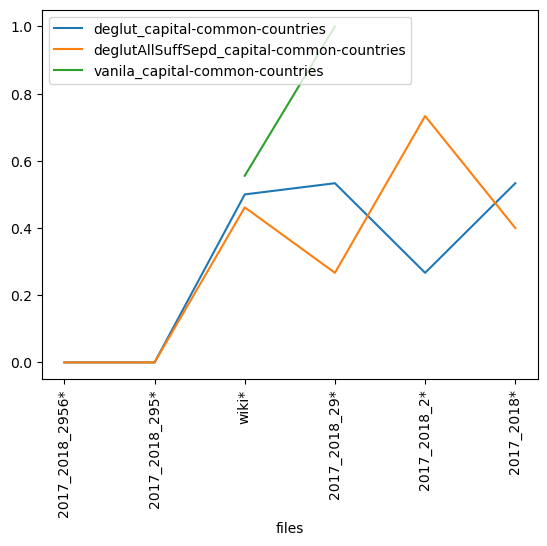

In [23]:
df[['deglut_capital-common-countries',
       'deglutAllSuffSepd_capital-common-countries',
       'vanila_capital-common-countries']].plot()
_ = plt.xticks(rotation=90)


# Investigating the strange results

In [24]:
def plot_accur_of_two_embeds(accuracies_vanila, accuracies_deglut, lname='vanila', rname='deglut', 
                             column='accuracy'):
    accuracies = accuracies_vanila.join(accuracies_deglut, rsuffix=f'-{rname}')
    plt.scatter(accuracies[f'{column}'], accuracies[f'{column}-{rname}'])
    plt.xlabel(lname)
    plt.ylabel(rname)
    for relation, stats in accuracies.iterrows():
        plt.annotate(relation, xy=(stats[f'{column}'], stats[f'{column}-{rname}']), rotation=45)

In [25]:
def get_analogy_scores_wrapper(filen_suff, deglut):
    vecs = KeyedVectors.load(f'{embed_dir}/sgns-300-{filen_suff}-{deglut}.gensim')
    return get_analogy_scores(vecs.wv, questions)

## Two kinds of deglut

### Greatest difference

In [26]:
nemeskey = get_analogy_scores_wrapper('2017_2018_2', 'deglutAllSuffSepd')

In [27]:
twopart = get_analogy_scores_wrapper('2017_2018_2', 'deglut')

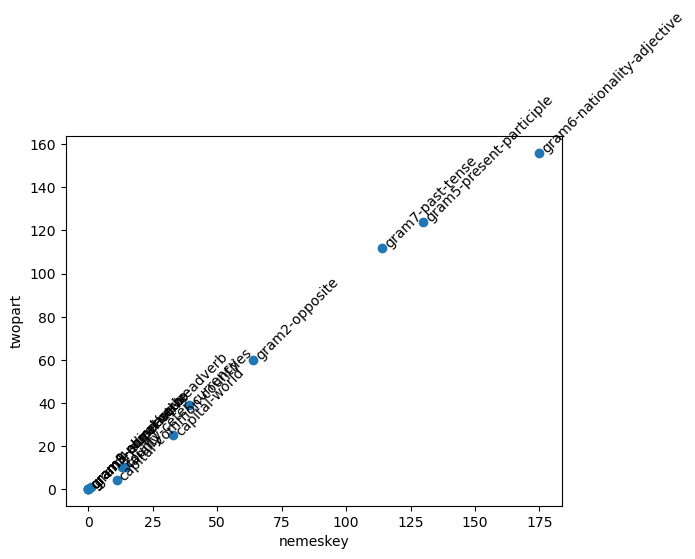

In [28]:
plot_accur_of_two_embeds(nemeskey, twopart, lname='nemeskey', rname='twopart', column='correct')

## Larger corpus is worse

## deglut 13G: `capital-common-countries` is worse in the larger corpus

### Nemeskey-style

In [29]:
vecs = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018_2-deglutAllSuffSepd.gensim')
accur_3G = get_analogy_scores(vecs.wv, questions)

In [30]:
vecs = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018-deglutAllSuffSepd.gensim')
accur_13G = get_analogy_scores(vecs.wv, questions)

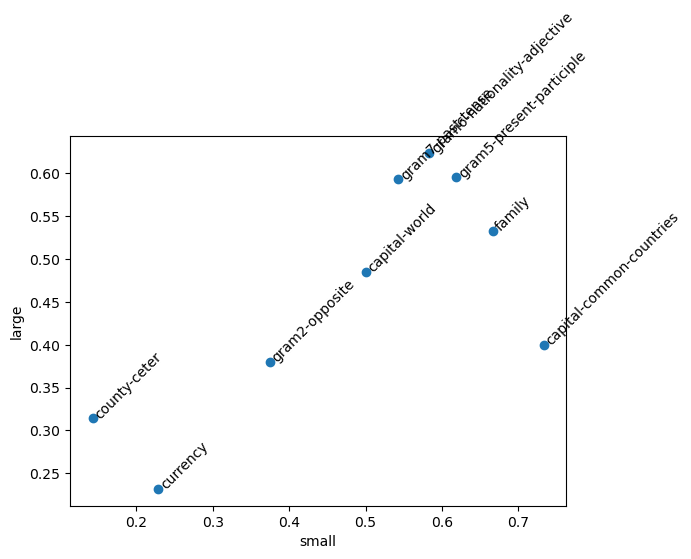

In [31]:
plot_accur_of_two_embeds(accur_3G, accur_13G, lname='small', rname='large')

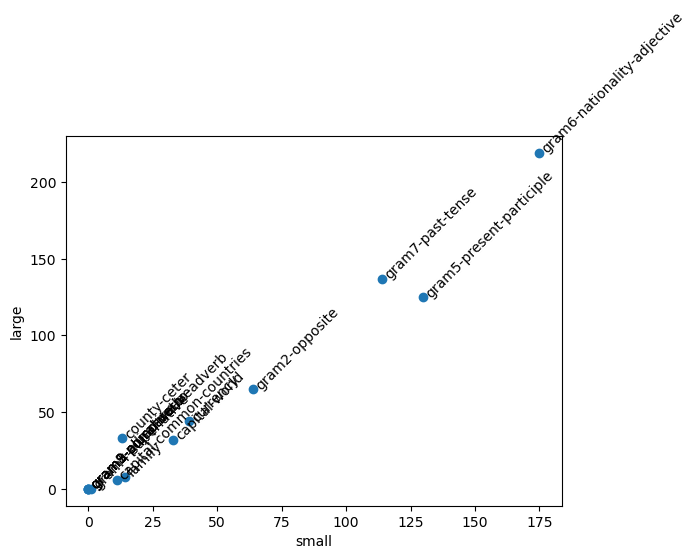

In [32]:
plot_accur_of_two_embeds(accur_3G, accur_13G, lname='small', rname='large', column='correct')
#plt.xscale('log')
#plt.yscale('log')

In [33]:
accur_3G.loc['capital-common-countries']

correct      11.000000
incorrect     4.000000
total        15.000000
accuracy      0.733333
Name: capital-common-countries, dtype: float64

In [34]:
accur_13G.loc['capital-common-countries']

correct       6.0
incorrect     9.0
total        15.0
accuracy      0.4
Name: capital-common-countries, dtype: float64

### two-part

In [35]:
vecs = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018_2-deglut.gensim')
accur_3G = get_analogy_scores(vecs.wv, questions)

In [36]:
vecs = KeyedVectors.load('/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018-deglut.gensim')
accur_13G = get_analogy_scores(vecs.wv, questions)

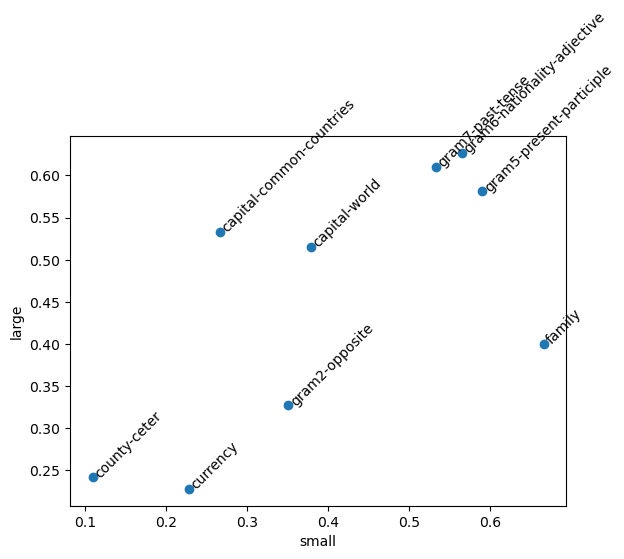

In [37]:
plot_accur_of_two_embeds(accur_3G, accur_13G, lname='small', rname='large')

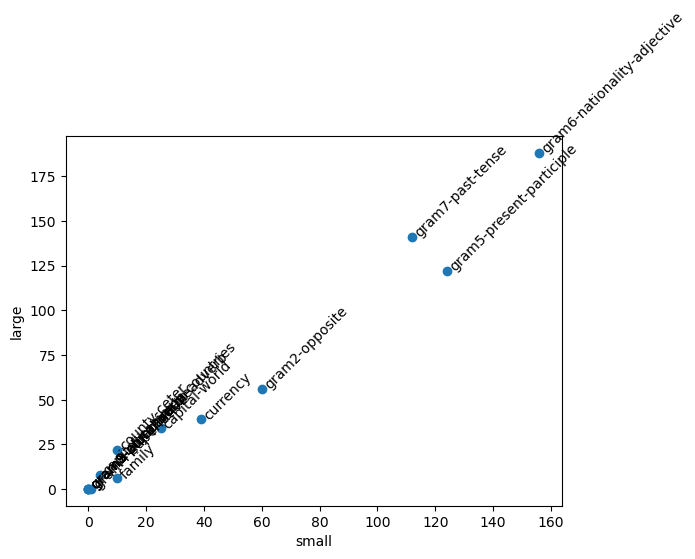

In [38]:
plot_accur_of_two_embeds(accur_3G, accur_13G, lname='small', rname='large', column='correct')
#plt.xscale('log')
#plt.yscale('log')

In [39]:
accur_3G.loc['capital-common-countries']

correct       4.000000
incorrect    11.000000
total        15.000000
accuracy      0.266667
Name: capital-common-countries, dtype: float64

In [40]:
accur_13G.loc['capital-common-countries']

correct       8.000000
incorrect     7.000000
total        15.000000
accuracy      0.533333
Name: capital-common-countries, dtype: float64

## Wiki vs similar-sized webcorpus

In [41]:
wiki_vanl = get_analogy_scores_wrapper('wiki', 'vanila')
wiki_dg_nemeskey = get_analogy_scores_wrapper('wiki', 'deglutAllSuffSepd')
wiki_dg_twopart = get_analogy_scores_wrapper('wiki', 'deglut')
webcorp_vanl = get_analogy_scores_wrapper('2017_2018_29', 'vanila')
webcorp_dg_nemeskey = get_analogy_scores_wrapper('2017_2018_29', 'deglutAllSuffSepd')
webcorp_dg_twopart = get_analogy_scores_wrapper('2017_2018_29', 'deglut')

### vanila

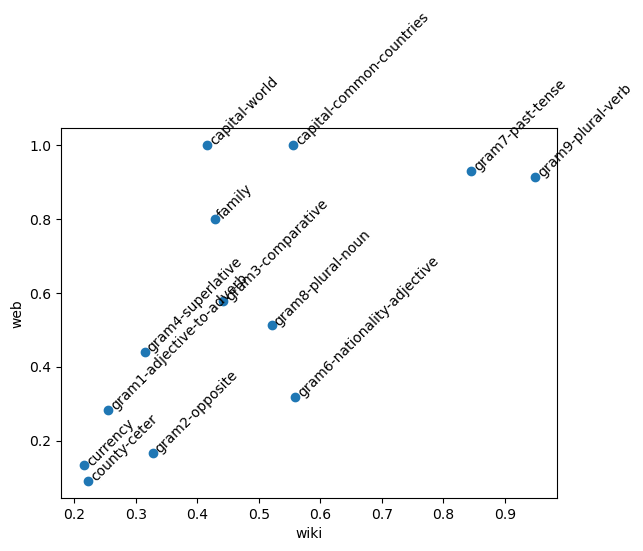

In [42]:
plot_accur_of_two_embeds(wiki_vanl, webcorp_vanl, lname='wiki', rname='web')

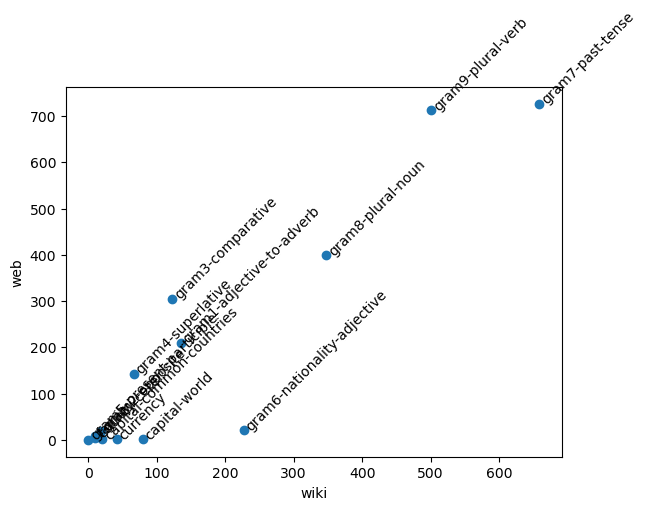

In [43]:
plot_accur_of_two_embeds(wiki_vanl, webcorp_vanl, lname='wiki', rname='web', column='correct')

In [44]:
wiki_vanl.loc['capital-common-countries']

correct      20.000000
incorrect    16.000000
total        36.000000
accuracy      0.555556
Name: capital-common-countries, dtype: float64

In [45]:
webcorp_vanl.loc['capital-common-countries']

correct      1.0
incorrect    0.0
total        1.0
accuracy     1.0
Name: capital-common-countries, dtype: float64

### two-part

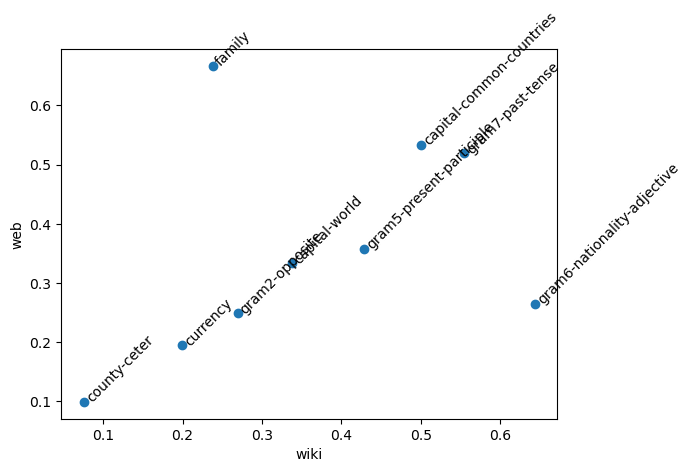

In [46]:
plot_accur_of_two_embeds(wiki_dg_twopart, webcorp_dg_twopart, lname='wiki', rname='web')

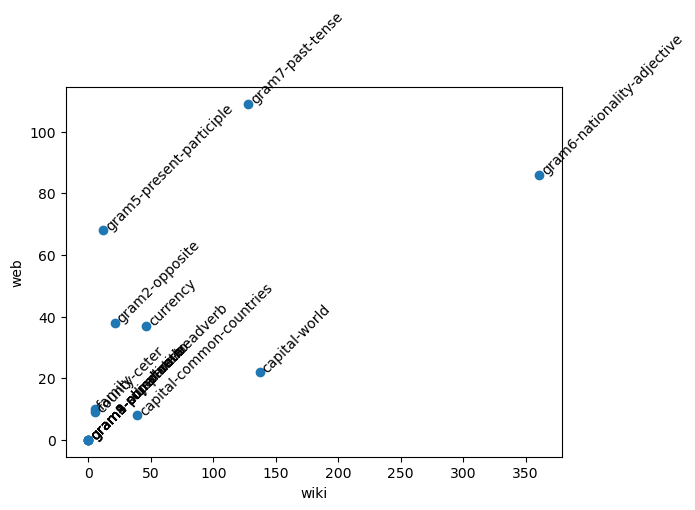

In [47]:
plot_accur_of_two_embeds(wiki_dg_twopart, webcorp_dg_twopart, lname='wiki', rname='web', column='correct')

### Nemeskey-style

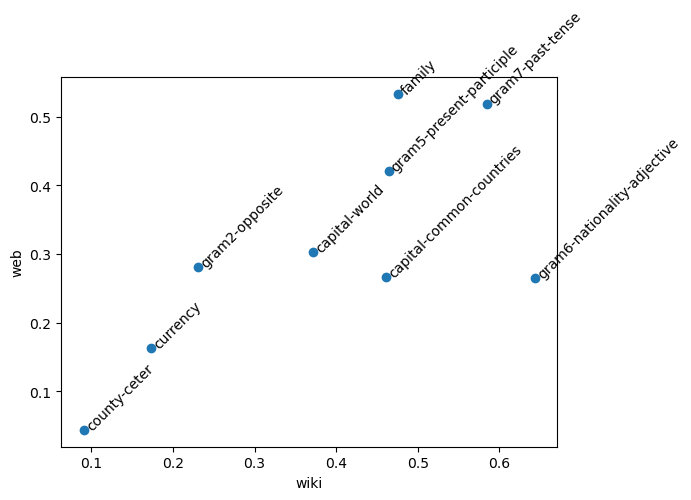

In [48]:
plot_accur_of_two_embeds(wiki_dg_nemeskey, webcorp_dg_nemeskey, lname='wiki', rname='web')

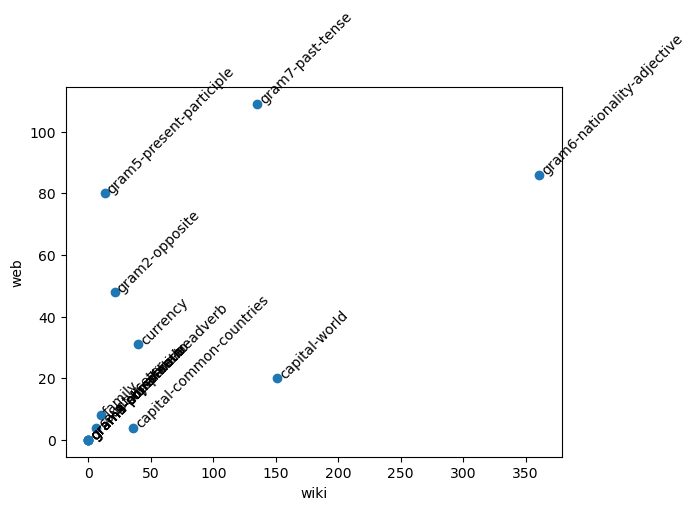

In [49]:
plot_accur_of_two_embeds(wiki_dg_nemeskey, webcorp_dg_nemeskey, lname='wiki', rname='web', column='correct')

# Sanity check of the gluten-free embed

In [50]:
vectors_vanila = KeyedVectors.load(
    '/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018-vanila.gensim').wv

In [51]:
vectors_vanila.most_similar('menekít')

[('kiűzné', 0.7763227820396423),
 ('kimenekít', 0.7755733728408813),
 ('hurczolt', 0.7723578810691833),
 ('kiparancsolja', 0.7708666920661926),
 ('megmenekíti', 0.769758403301239),
 ('öldökli', 0.7693419456481934),
 ('visszaűzi', 0.7689425349235535),
 ('megrohanó', 0.7678847312927246),
 ('menekítenek', 0.767638623714447),
 ('kikergetett', 0.7662070393562317)]

In [52]:
accuracies_vanila = get_analogy_scores(vectors_vanila, questions)

In [53]:
vectors_deglut = KeyedVectors.load(
    '/mnt/permanent/Language/Hungarian/Embed/webcorpus2.0/sgns-300-2017_2018-deglut.gensim').wv

In [54]:
vectors_deglut.most_similar('menekít')

[('kimenekít', 0.7151190042495728),
 ('elmenekít', 0.6811343431472778),
 ('menekített', 0.6797430515289307),
 ('költöztet', 0.6522114276885986),
 ('hurcol', 0.64631587266922),
 ('menekül', 0.631571352481842),
 ('áttelepít', 0.6276301741600037),
 ('hurczol', 0.625426173210144),
 ('kiszöktet', 0.6162187457084656),
 ('zsuppol', 0.6118050217628479)]

In [55]:
accuracies_deglut = get_analogy_scores(vectors_deglut, questions)